# The objective is to use the Q-learning technique to train an agent in The Taxi Problem. In this problem, there are four designated locations for picking up and dropping off passengers (Red, Green, Yellow, and Blue) on a 5x5 grid. The taxi starts at a random square, and the passenger begins at one of the designated locations. The goal is to move the taxi to the passenger’s location, pick up the passenger, take them to their destination, and drop them off at the indicated location. The player receives positive rewards for successfully dropping the passenger at their destination and negative rewards for failed attempts to pick up or drop off the passenger.

In [1]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 8.3 MB/s eta 0:00:00


We create an environment and display it on the screen. For this, we define a function to print our environment.

In [2]:
# Seed used to initialize the environment, ensuring reproducibility
seed = 1

# Create the Taxi-v3 environment
environment = gym.make("Taxi-v3", render_mode='ansi').env
environment.reset(seed=seed)

# Helper function to display the current state of the environment
def print_env(state):
    env_str = state.render()
    print(env_str)

# Print the initial state of the environment
print_env(environment)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




The colored rectangle represents the taxi: yellow when it has no passenger and green when it has a passenger. '|' represents a wall that the taxi cannot cross. R, G, Y, and B are points of interest, which are the possible pickup and drop-off locations. The blue letter indicates the current passenger pickup location, and the purple letter represents the current drop-off destination.

If we change the seed, the state of the environment changes.

In [3]:
# A different seed
seed = 3

environment = gym.make("Taxi-v3", render_mode='ansi').env
environment.reset(seed=seed)

print_env(environment)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Let's explore the state and action spaces:

In [4]:
print(f"Action Space: {environment.action_space}")
print(f"State Space: {environment.observation_space}")

Action Space: Discrete(6)
State Space: Discrete(500)


There are 6 actions, which correspond to:
 * 0 = go South
 * 1 = go North
 * 2 = go East
 * 3 = go West
 * 4 = pick up passenger
 * 5 = drop off passenger

The cardinal directions follow the convention of North pointing upwards. Picking up or dropping off the passenger only has an effect if the taxi is on the same square as the passenger and at one of the points of interest.

Our agent will need to choose the action to take at each step. Gymnasium provides functions for this. If we want to move south, for example:

In [5]:
seed = 1
environment = gym.make("Taxi-v3", render_mode='ansi').env
environment.reset(seed=seed)
print_env(environment)

action = 0  # South
environment.step(action)

print_env(environment)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Now we want to program an intelligent agent, and for this, we will adhere to the following interface.

In [6]:
class Agent:
    def choose_action(self, state, max_action) -> int:
        """Choose the action to take in the current state within the action space"""
        pass

    def learn(self, previous_state, next_state, action, reward):
        """Learn from the transition tuple
            - previous_state: the state from which the agent started
            - next_state: the state to which the agent arrived
            - action: the action that took the agent from previous_state to next_state
            - reward: the reward received in the transition
        """
        pass

In [7]:
def run_episode(agent, seed):
    environment = gym.make("Taxi-v3", render_mode='ansi').env

    iterations = 0
    penalties, reward = 0, 0
    cumulative_reward = 0

    frames = []  # For animation

    done = False
    truncated = False
    previous_state, info = environment.reset(seed=seed)
    while not done and not truncated:
        # Ask the agent to choose an action from the available actions (0..environment.action_space.n)
        action = agent.choose_action(previous_state, environment.action_space.n)

        # Execute the action
        next_state, reward, done, truncated, info = environment.step(action)

        # Inform the agent to learn from the experience
        agent.learn(previous_state, next_state, action, reward)

        # If the agent attempted an incorrect pickup/drop-off
        if reward == -10:
            penalties += 1

        cumulative_reward += reward

        # Append each frame to the dictionary for animation
        frames.append({
            'frame': environment.render(),
            'state': next_state,
            'action': action,
            'reward': reward
        })

        previous_state = next_state
        iterations += 1

    return iterations, penalties, cumulative_reward

We define a random agent that does not learn:

In [8]:
import random

class RandomAgent(Agent):
    def choose_action(self, state, max_action) -> int:
        # Choose a random action
        return random.randrange(max_action)

    def learn(self, previous_state, next_state, action, reward):
        # No learning
        pass

Testing the agent in action:

In [9]:
agent = RandomAgent()
seed = 1
episode_iterations = []
episode_penalties = []
reward_per_step_episodes = []

for i in range(100):
    num_iterations, penalties, cumulative_reward = run_episode(agent, seed)
    episode_iterations.append(num_iterations)
    episode_penalties.append(penalties)
    reward_per_step_episodes.append(cumulative_reward / num_iterations)

And obtain metrics accordingly:

In [10]:
import numpy as np
print(f"An average of {np.mean(episode_iterations)} iterations were performed")
print(f"An average of {np.mean(episode_penalties)} penalties were received")
print(f"The average reward per step across all episodes is: {np.mean(reward_per_step_episodes)}")

An average of 2529.82 iterations were performed
An average of 819.98 penalties were received
The average reward per step across all episodes is: -3.8742356969472227


Next, we will define a learning-capable agent to improve its performance. For this purpose, we will use a Q matrix of size 500x6 (500 possible states and 6 possible actions), initialized with zeros, where the values of each entry represent the expected utility of taking a specific action in a given state. The learning process is carried out as follows:


*   The discount factor (γ) and the exploration factor (ϵ) are initialized.
*   At each time step, the agent selects an action based on an epsilon-greedy strategy. With a probability of ϵ, it chooses a random action to explore the environment; otherwise, it chooses the action with the highest Q-value to exploit the knowledge gained.
*   Q-table Update: After performing an action and observing the reward and new state, the agent updates the Q-values using the Q-learning update formula: $Q(s,a)  \leftarrow r(s,a) + \gamma * máx Q(s',a')$, where:

  *   $s$ is the current state.
  *   $a$ is the action taken.
  *   $r(s,a)$ is the reward obtained by taking action a in state s
  *   $s'$ is the new state after performing the action.
  *   $a'$ is one of the 6 possible actions.
  *   $γ$ is the discount factor.


In [11]:
import numpy as np
import random

class RLAgent(Agent):

    def __init__(self, environment) -> None:
        super().__init__()
        self.gamma = 0.1  # discount factor
        self.epsilon = 0.1

        # Q-table for each (state, action) pair, giving the Q value
        # Size 500 x 6
        # Initialized with 0s
        self.q_table = {}
        for state in range(500):
            self.q_table[state] = {}
            for action in range(6):
                self.q_table[state][action] = 0

        self.q_table_backup = {}

    def save_q_table(self):
        self.q_table_backup = self.q_table

    def restore_q_table(self):
        self.q_table = self.q_table_backup

    def unvisited_count(self):
        count = 0
        for state in range(500):
            for action in range(6):
                if self.q_table[state][action] == 0:
                    count += 1
        return count

    def get_q_table(self):
        return self.q_table

    def choose_action(self, state, max_action) -> int:
        # Epsilon-Greedy:
        # With probability ε, explore; otherwise, exploit
        action = 0
        if random.random() < self.epsilon:
            # Exploration: choose a random action
            action = random.randint(0, max_action - 1)
        else:
            # Exploitation: choose the action with the highest estimated value
            best_action = 0
            best_reward = self.q_table[state][best_action]
            for possible_action in range(1, max_action):
                if self.q_table[state][possible_action] > best_reward:
                    best_action = possible_action
                    best_reward = self.q_table[state][possible_action]
            action = best_action

        return action

    def learn(self, previous_state, next_state, action, reward):
        best_action = 0
        best_reward = self.q_table[next_state][best_action]
        for possible_action in range(1, 6):
            if self.q_table[next_state][possible_action] > best_reward:
                best_action = possible_action
                best_reward = self.q_table[next_state][possible_action]

        self.q_table[previous_state][action] = reward + self.gamma * best_reward


100 episodes are run with the same seed, and metrics are obtained:

In [12]:
import numpy as np
agent = RLAgent(environment)
seed = 1
episode_iterations = []
episode_penalties = []
reward_per_step_episodes = []

for i in range(100):
    num_iterations, penalties, cumulative_reward = run_episode(agent, seed)
    episode_iterations.append(num_iterations)
    episode_penalties.append(penalties)
    reward_per_step_episodes.append(cumulative_reward / num_iterations)

print(f"An average of {np.mean(episode_iterations)} iterations were performed")
print(f"An average of {np.mean(episode_penalties)} penalties were received")
print(f"The average reward per step across all episodes is: {np.mean(reward_per_step_episodes)}")

An average of 43.35 iterations were performed
An average of 3.21 penalties were received
The average reward per step across all episodes is: 0.04790345008180545


# Defining agent parameters:

Once the agent is created, before using it, the values of parameters $\gamma$ and $\epsilon$ will be determined. To do this, executions will be compared using the averages of iterations, penalties, and rewards per step, evaluated over 1000 episodes (with a seed set to 1).

Average iterations:

|gamma\epsilon| 0.7 | 0.4 | 0.3 |  0.1 |
|---|---|---|---|---|
|0.9| 245.742 | 270.618 | 325.69 | 848.057 |
|0.8| 176.348 | 200.033 | 237.097 | 583.622 |
|0.7| 140.412 | 139.52  | 167.746 | 411.492 |
|0.6| 116.31 | 106.821 | 130.436 | 316.602 |
|0.5| 98.648  | 77.627 | 90.226 | 187.773 |
|0.1| 68.998 | 30.646 | 26.392 | 18.22 |

Average penalties:

|gamma\epsilon| 0.7 | 0.4 | 0.3 | 0.1 |
|---|---|---|---|---|
|0.9| 67.776 | 80.485 | 101.919 | 288.786 |
|0.8| 40.205 | 33.379 | 34.396 | 69.108 |
|0.7| 29.507 | 16.39  | 14.616 | 12.015 |
|0.6| 25.403 | 13.659 | 12.577 | 10.676 |
|0.5| 21.844 | 10.151 |  8.89 | 6.317 |
|0.1| 14.981 | 3.81 |  2.598 | 0.704 |

Average reward per step:

|gamma\epsilon| 0.7 | 0.4 | 0.3| 0.1 |
|---|---|---|---|---|
|0.9| -3.3477852698839694 | -3.613231866146435 | -3.76060694757402 | -4.206595067798411 |
|0.8|  -2.9304408027608844 | -2.5441470560676325 | -2.390162917554132 | -2.599911874883949 |
|0.7|  -2.6502495103385244 | -1.7563092178807302  |  -1.5252514658582272 |-1.1071874958779444 |
|0.6| -2.6552184365832137 | -1.763847200715347 |  -1.5207334018551515 | -1.0879042170807016 |
|0.5| -2.6629314230151704 | -1.7213518408783393 | -1.456784380384543 | -1.00892831205213 |
|0.1| -2.474775989692254 | -1.08690699043825 | -0.6584442816362513 | 0.30484284857164884 |

Additionally, tests were conducted with a decreasing $\epsilon$, a commonly used technique to explore more initially and, as learning progresses, reduce exploration to exploit the acquired knowledge.

The $\epsilon$ value was decreased in increments of 0.001 until reaching a lower limit of 0.1. The results obtained were as follows:

|gamma| Iterations | Penalties | Reward per Step |
|---|---|---|--- |
|0.9| 899.255 | 306.272 | -4.131152368845488 |
|0.8| 582.138 | 70.183 | -2.537010242203745 |
|0.7| 406.819 | 11.88 | -1.0994311544467872 |
|0.6| 279.485 | 9.498 | -1.0764667502474896 |
|0.5| 191.079 | 6.741 | -1.062652899059444 |
|0.4| 92.152 | 3.301 | -0.7908089397681026 |
|0.3| 78.04   | 2.838 | -0.7443715373103262 |
|0.2| 22.2    | 0.986 |  0.253289958508605  |
|0.1| 19.196  | 0.933 |  0.27047374289570586|
|0.05| 76.437 | 2.694 | -0.7395249825876712 |

After all the tests, the most promising results were obtained with $\gamma$=0.1 and a fixed $\epsilon$. Therefore, these values will be used in the following stages. Below is a graph representing the number of iterations required to reach the goal in each of the first 100 episodes executed.

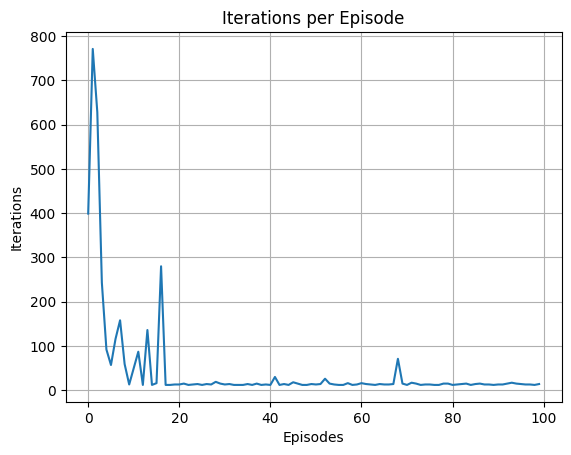

In [13]:
import matplotlib.pyplot as plt

# Create the line plot
plt.plot(episode_iterations[:100])
plt.xlabel('Episodes')
plt.ylabel('Iterations')
plt.title('Iterations per Episode')
plt.grid(True)

plt.show()

# Performance with a different seed:

To evaluate the agent with a different seed, a seed other than 1 is chosen (with a different origin and destination). Seed 46 is selected for this purpose.

In [14]:
seed = 46
environment = gym.make("Taxi-v3", render_mode='ansi').env
environment.reset(seed=seed)
print_env(environment)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [15]:
seed = 46
episode_iterations = []
episode_penalties = []
reward_per_step_episodes = []

for i in range(1000):
    num_iterations, penalties, cumulative_reward = run_episode(agent, seed)
    episode_iterations.append(num_iterations)
    episode_penalties.append(penalties)
    reward_per_step_episodes.append(cumulative_reward / num_iterations)

print(f"An average of {np.mean(episode_iterations)} iterations were performed")
print(f"An average of {np.mean(episode_penalties)} penalties were received")
print(f"The average reward per step across all episodes is: {np.mean(reward_per_step_episodes)}")

An average of 21.584 iterations were performed
An average of 0.865 penalties were received
The average reward per step across all episodes is: -0.11233153601320725


Since the destination is different, none of the Q-matrix entries with this destination were completed in the previous iterations. Therefore, it is expected that no improvements will be seen in the metrics, as the knowledge acquired from training with seed 1 is not useful when using seed 46.

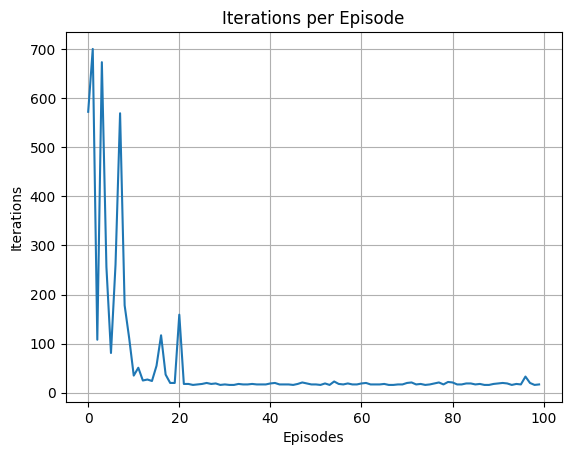

In [16]:
# Create the line plot
plt.plot(episode_iterations[:100])
plt.xlabel('Episodes')
plt.ylabel('Iterations')
plt.title('Iterations per Episode')
plt.grid(True)

plt.show()


# Agent improvement:

In [18]:
import matplotlib.pyplot as plt
import numpy as np

agent = RLAgent(environment)
seed = 1
episode_iterations = []
episode_penalties = []
reward_per_step_episodes = []

for i in range(1000):
    num_iterations, penalties, cumulative_reward = run_episode(agent, seed)

# Count unvisited entries in the Q-table
unvisited_entries = agent.unvisited_count()
print("Unvisited entries: " + str(unvisited_entries))

Unvisited entries: 2400


Regarding exploration, it was observed that, after executing a thousand episodes, 600 out of the 3000 possible cells in the Q-matrix were completed, leaving 2400 with a value of 0. Even if ϵ was set to 1, where the agent would aim to explore every iteration without learning, the maximum number of possible cells completed would still be 600. Therefore, with the ϵ selected earlier, it can be concluded that the agent explores all possible options for the chosen seed.

The 600 completed cells, given the selected seed, result from the fact that there are 25 different positions for the taxi, 4 different positions for the passenger (3 of the 4 possible origin locations, and additionally when inside the taxi), 1 destination position that does not change during the executions, and 6 different actions to take in each state. We will use an example to explain this further, assuming that the passenger starts at B, and the destination is R. Under these circumstances, the taxi can move through the 25 different positions (with the taxi without the passenger) and perform 6 different actions in each position. Additionally, the taxi driver could pick up the passenger at B and take them to G or Y, to later perform a "dropoff." Then, with the passenger at G or Y, the taxi could move to the 25 positions and, once again, perform the 6 actions in each position. Finally, the taxi driver could pick up the passenger, and with them inside, move around the 25 positions, performing the 6 actions in each one. The taxi driver would not be able to perform a "dropoff" (with the passenger inside the taxi) at R and then continue moving, as, in that case, the passenger would reach the destination, and the episode would end.

Given that only 600 entries were completed for a single seed and, as mentioned in the previous section, this information is not useful for a new seed with a different destination, a possible solution to improve the agent's performance with an arbitrary seed would be to sufficiently "train" the agent with different seeds until a certain threshold of entries in the Q-matrix is completed.

Ideally, it would be possible to cover 100% of the entries in the matrix, but after some testing, it was observed that the time required to complete more than 80% increases significantly.

In [21]:
agent = RLAgent(environment)
# Q-table size is 500 x 6
# The goal is to complete 80% of the Q-table
# Leaving 20% unvisited
seeds = []
threshold = 500 * 6 * 0.20
episodes = 100

while agent.unvisited_count() > threshold:
    seed = random.randint(1, 1000)
    seeds.append(seed)
    for i in range(episodes):
        num_iterations, penalties, cumulative_reward = run_episode(agent, seed)

agent.save_q_table()
print(f"Seeds used: {seeds}")

Seeds used: [502, 230, 192, 760, 943, 88, 608, 199, 906]


With this agent, which has at least 80% of its Q-table entries covered, its performance is tested with 10 arbitrary seeds and compared to a new, untrained agent.

In [22]:
seeds = []
first_occurrences_trained = []
first_occurrences_new = []
for i in range(10):
    seed = random.randint(1, 1000)
    seeds.append(seed)
    agent.restore_q_table()
    new_agent = RLAgent(environment)
    iterations_trained = []
    iterations_new = []

    for i in range(1000):
        num_iterations_new, penalties_new, cumulative_reward_new = run_episode(new_agent, seed)
        iterations_new.append(num_iterations_new)
        num_iterations_trained, penalties_trained, cumulative_reward_trained = run_episode(agent, seed)
        iterations_trained.append(num_iterations_trained)

    min_iterations_new = min(iterations_new)
    first_occurrence_new = iterations_new.index(min_iterations_new) + 1
    first_occurrences_new.append(first_occurrence_new)

    min_iterations_trained = min(iterations_trained)
    first_occurrence_trained = iterations_trained.index(min_iterations_trained) + 1
    first_occurrences_trained.append(first_occurrence_trained)

In [23]:
print(f"Seeds: {seeds}")
print(f"First occurrence (new agent): {first_occurrences_new}")
print(f"First occurrence (trained agent): {first_occurrences_trained}")

Seeds: [437, 977, 672, 51, 587, 203, 56, 774, 44, 811]
First occurrence (new agent): [17, 19, 15, 15, 15, 18, 15, 9, 28, 21]
First occurrence (trained agent): [1, 14, 6, 1, 1, 3, 10, 1, 4, 3]


After training with the seeds [502, 230, 192, 760, 943, 88, 608, 199, 906] (1000 iterations with each), a table is created to compare, for 10 arbitrary seeds, when the first episode with the minimum number of iterations occurred for both the untrained agent and the trained agent.

|Arbitrary Seed| 	Untrained Agent | Trained Agent |
|---|---|---|
|44  |28 |4 |
|51 |15 |1 |
|56 |15 |10  |
|203 |18 |3 |
|437 |17 |1 |
|587 |15 |1  |
|672 |15 |6  |
|774 |9 |1  |
|811 |21 |3  |
|977 |19 |14  |

It can be observed that for all the seeds tested, there was an improvement in the number of episodes required to reach the minimum with the trained agent.